In [23]:
from google.colab import drive
from os.path import join 

ROOT = "/content/gdrive/"
drive.mount(ROOT)

Mounted at /content/gdrive/


# Exploratory Data Analysis 학습 데이터 파악

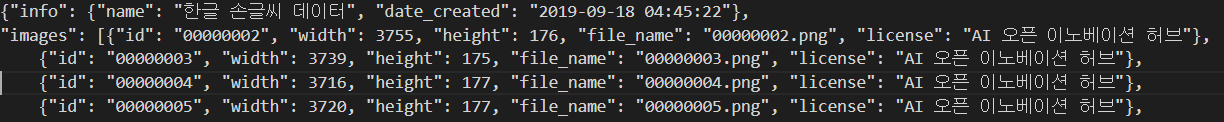

### 손글씨 데이터 파악

In [ ]:
# 손글씨 데이터에서 필요한 것들 (for GAN) 
# text(클래스) : json_data['annotations'][idx]['text']
# 성별, 연령대 : json_data['annotations'][idx]['attributes']  for pretraining - 잘 쓴 손글씨(여성) => 나중에 보니까 다 여성임 -> 나눌 필요 없다.
# 이미지 크기 : json_data['images'][idx]['width'] 또는 ['height']
# 파일명 : json_data['images'][idx]['file_name']
import json

In [ ]:
def getListOfHandWritingFileNames(listOfFemaleHandWritingFileNames, listOfMaleHandWritingFileNames):
    handwritingMetaFile_location = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/handwriting_data_info1.json'
    printedMetaFile_location = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/printed_data_info.json'

    with open(handwritingMetaFile_location, 'r') as f:
        hw_json_data = json.load(f)

    hw_ClassToFileNames, hw_WordsToFileNames= {}, {}
    hw_syllableDataLength = 0

    for idx, img_data in enumerate(hw_json_data['images']):
        # idx 번째 이미지 데이터들에 대해 {클래스 : [파일명, 파일명, ...]}
        class_ = hw_json_data['annotations'][idx]['text']
        fileName = hw_json_data['images'][idx]['file_name']
        if len(class_) == 1:    
            # 한 글자인 경우만 ClassToFileNames에 넣기
            if class_ not in hw_ClassToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                hw_ClassToFileNames[class_] = [] # 빈 리스트 생성
            hw_ClassToFileNames[class_].append(fileName)
            hw_syllableDataLength += 1
            if hw_json_data['annotations'][1]['attributes']['gender'] == '여':
                listOfFemaleHandWritingFileNames.append(fileName)
            else:
                listOfMaleHandWritingFileNames.append(fileName)
        else:
            # 단어, 문장의 경우 WordsToFileNames에 넣기
            if class_ not in hw_WordsToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                hw_WordsToFileNames[class_] = [] # 빈 리스트 생성
            hw_WordsToFileNames[class_].append(fileName)
    
    print("*** Handwriting Data Description ***")
    print("\t전체 데이터 수 : ", len(hw_json_data['images']) )# 여기에는 문장 데이터, 단어 데이터, 음절 데이터 모두 포함됨
    print("\t음절 클래스 수 : ", len(hw_ClassToFileNames) ) # 한국어 글자 종류는 11,172가지.
    print("\t단어/문장 클래스 수: ", len(hw_WordsToFileNames))
    print("\t음절 데이터 수 : ", hw_syllableDataLength)
    print("\t단어/문장 데이터 수 : ", len(hw_json_data['images']) - hw_syllableDataLength)
    print(f"\t한 음절 당 평균 {hw_syllableDataLength/len(hw_ClassToFileNames)} 개 손글씨 데이터 존재함")

### 인쇄체 데이터 파악

In [ ]:
def getListOfPrintedFileNames(listOfPrintedFileNames):
    printedMetaFile_location = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/printed_data_info.json'

    with open(printedMetaFile_location, 'r') as f:
        p_json_data = json.load(f)

    p_ClassToFileNames, p_WordsToFileNames= {}, {}
    p_syllableDataLength = 0

    for idx, img_data in enumerate(p_json_data['images']):
        # idx 번째 이미지 데이터들에 대해 {클래스 : [파일명, 파일명, ...]}
        class_ = p_json_data['annotations'][idx]['text']
        fileName = p_json_data['images'][idx]['file_name']
        if len(class_) == 1:    
            # 한 글자인 경우만 ClassToFileNames에 넣기
            if class_ not in p_ClassToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                p_ClassToFileNames[class_] = [] # 빈 리스트 생성
            p_ClassToFileNames[class_].append(fileName)
            p_syllableDataLength += 1
            listOfPrintedFileNames.append(fileName)

        else:
            # 단어, 문장의 경우 WordsToFileNames에 넣기
            if class_ not in p_WordsToFileNames.keys(): # idx번째 이미지의 클래스가 새로운 클래스이면
                p_WordsToFileNames[class_] = [] # 빈 리스트 생성
            p_WordsToFileNames[class_].append(fileName)
    print("*** Printed Data Description ***")
    print("\t전체 데이터 수 : ", len(p_json_data['images']) )# 여기에는 문장 데이터, 단어 데이터, 음절 데이터 모두 포함됨
    print("\t음절 클래스 수 : ", len(p_ClassToFileNames) ) # 한국어 글자 종류는 11,172가지.
    print("\t단어/문장 클래스 수: ", len(p_WordsToFileNames))
    print("\t음절 데이터 수 : ", p_syllableDataLength)
    print("\t단어/문장 데이터 수 : ", len(p_json_data['images']) - p_syllableDataLength)
    print(f"\t한 음절 당 평균 {p_syllableDataLength/len(p_ClassToFileNames)} 개 손글씨 데이터 존재함")

    return p_ClassToFileNames

## GAN pretrain에 사용할 데이터 : 인쇄체, train에 사용할 데이터 : 손글씨(여성)

In [ ]:
# zip 파일 읽기 
from zipfile import ZipFile
import io
from PIL import Image
import numpy as np
import torch

In [ ]:
# 인쇄체 음절 이미지의 파일명  for pretrain
listOfPrintedFileNames = []
# 여성 필기체 음절 이미지의 파일명  for pretrain
listOfFemaleHandWritingFileNames = []
# 남성 필기체 음절 이미지의 파일명  for train
listOfMaleHandWritingFileNames = []

getListOfHandWritingFileNames(listOfFemaleHandWritingFileNames, listOfMaleHandWritingFileNames)
p_ClassToFileNames = getListOfPrintedFileNames(listOfPrintedFileNames)

print("여성 필기체 data 수 : ", len(listOfFemaleHandWritingFileNames))
print("남성 필기체 data 수 : ", len(listOfMaleHandWritingFileNames))
print("인쇄체 data 수 : ", len(listOfPrintedFileNames))

*** Handwriting Data Description ***
	전체 데이터 수 :  1170622
	음절 클래스 수 :  11172
	단어/문장 클래스 수:  6054
	음절 데이터 수 :  761109
	단어/문장 데이터 수 :  409513
	한 음절 당 평균 68.1264769065521 개 손글씨 데이터 존재함
*** Printed Data Description ***
	전체 데이터 수 :  878100
	음절 클래스 수 :  11172
	단어/문장 클래스 수:  6054
	음절 데이터 수 :  575350
	단어/문장 데이터 수 :  302750
	한 음절 당 평균 51.499283924095955 개 손글씨 데이터 존재함
여성 필기체 data 수 :  761109
남성 필기체 data 수 :  0
인쇄체 data 수 :  575350


In [ ]:
female_hw_fileName_inZIP1 = []
female_hw_fileName_inZIP2 = []

# 1_syllable/00192279.png : zip1파일 내의 데이터 중 가장 마지막 # print(zipObj.namelist()[-1]) 
# listOfFemale ... 원소 : 01200901.png
for filename in listOfFemaleHandWritingFileNames:
    if filename[:len('00192279')] < '00192279':
        female_hw_fileName_inZIP1.append('1_syllable/'+ filename)
    else:
        female_hw_fileName_inZIP2.append('2_syllable/'+ filename)

In [ ]:
# 위의 셀 모두 실행했을 떄 RAM : 1.76 GB 소모

# 음절 데이터 수 :  729251
# 위의 meta data에 따르면 761109여야 하는데 부족함. 
location1 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/01_handwriting_syllable_images.zip'
location2 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/02_handwriting_syllable_images.zip'
train_data_list = [] # 학습에 활용할 데이터

with ZipFile(location1, 'r') as zipObj: # 첫 번째 element는 empty
    for fileName in female_hw_fileName_inZIP1:
        # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족
        try:
            zipRead = zipObj.read(fileName)
            buffer = io.BytesIO(zipRead)
            encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
            train_data_list.append(encoded_img)
        except:
            pass # meta-data와 실제 data의 간극 무시

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  from ipykernel import kernelapp as app


In [ ]:
print("손글씨 데이터의 zip1에서 얻은 pretrain용 data(여성 손글씨) 수 : ", len(pretrain_data_list))

손글씨 데이터의 zip1에서 얻은 pretrain용 data(여성 손글씨) 수 :  135839


위의 셀 모두 실행했을 떄 RAM : 2.27 GB 소모
여기서 RAM 부하 문제 발생. colab RAM 12.69GB.

In [ ]:
# 의도적 분할. RAM이 데이터 감당 못해서 cell 나눔
with ZipFile(location2, 'r') as zipObj: 
    for fileName in female_hw_fileName_inZIP2[:]: # 여기 범위 줄일 것
        try:
            zipRead = zipObj.read(fileName)
            print("ㅇ")
            buffer = io.BytesIO(zipRead)
            encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
            train_data_list.append(encoded_img)
        except:
            pass

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  import sys


In [ ]:
print("손글씨 데이터 전체에서 얻은 pretrain용 data(여성 손글씨) 수 : ", len(train_data_list))

In [ ]:
# 인쇄체 zip 데이터 읽기
location3 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/01_printed_syllable_images.zip'
pretrain_data_list = [] # 학습에 활용할 데이터
nonexisit_file_list = []

with ZipFile(location3, 'r') as zipObj: # 첫 번째 element는 empty
    for fileName in listOfPrintedFileNames: 
        # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족 # "There is no item named 'syllable/00532659.png' in the archive"
        # meta-data에서는 575350 개 있다고 했으나 실제는 532659 개 있음 
        try:
            zipRead = zipObj.read('syllable/'+ fileName) 
            buffer = io.BytesIO(zipRead)
            encoded_img = np.frombuffer(buffer.getvalue(), dtype = np.uint8)
            pretrain_data_list.append(encoded_img)
        except:
            nonexisit_file_list.append(fileName)
            pass 

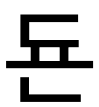

In [ ]:
import cv2



In [ ]:
len(nonexisit_file_list)

42691

In [ ]:
p_ClassToFileNames.values() # 11172

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
nonexisit_file_list[-1]

'02511536.png'

In [ ]:

len(pretrain_data_list)
len(p_ClassToFileNames.values()) # 11172

letterClassList = []
# p_ClassToFileNames # 더 많음
for filename in pretrain_data_list:
    for idx, sameClassFileNameList in enumerate(p_ClassToFileNames.values()):
        if filename in sameClassFileNameList:
            letterClassList.append(idx) # 같은 클래스 끼리 같은 idx 가짐 [0, 123, 28784, ... ] 각 숫자는 클래스 의미
print(len(pretrain_data_list))
print(len(letterClassList))
nonexisit_file_list

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if __name__ == '__main__':


gan에서 필요한 데이터 : 파일명, 이미지데이터, 클래스

In [ ]:
import csv

for idx, key in enumerate(p_ClassToFileNames.keys()):
    location = '/content/drive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital/GAN/data/PrintedFilenames.csv'

    filenameList = p_ClassToFileNames[key]
    if filenameList in 

    with open(location, 'w',newline='') as f:
        write = csv.writer(f) 
        write.writerow([1, "김정수", False])
    with oepn(location1, 'w', newline='') as f1:
        write = 
     
import csv list_name = ["가방", "스타크래프트", "핸드폰", "손전등", "스위치"] with open("filename.csv", 'w') as file: writer = csv.writer(file) writer.writerow(list_name)

출처: https://nomalcy.tistory.com/71 [NOMALCY]

TypeError: ignored

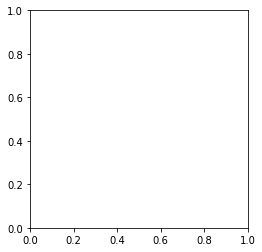

In [ ]:
img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim, from_numpy
import cv2

# listOfPrintedFileNames 

# pretrain용 인쇄체 dataloader 구현
class SyllablePrintedDataset(Dataset):
    def __init__(self):
        location = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/02.인쇄체/01_printed_syllable_images.zip'
        pretrain_data_list = [] # 학습에 활용할 데이터

        with ZipFile(location, 'r') as zipObj: # 첫 번째 element는 empty
            for fileName in listOfPrintedFileNames: 
                # meta-data와 실제 data 간의 차이가 존재. 실제 data는 더 부족 # "There is no item named 'syllable/00532659.png' in the archive"
                # # meta-data에서는 575350 개 있다고 했으나 실제는 532659 개 있음 
                try:
                    zipRead = zipObj.read('syllable/'+ fileName) 
                    buffer = io.BytesIO(zipRead)
                    encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
                    pretrain_data_list.append(encoded_img)
                except:
                    pass 
        self.dataset = pretrain_data_list

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        data = self.dataset[index] 
        return torch.cuda.FloatTensor(data) / 255.0
    
    def get_image(self, index):
        img = cv2.imdecode(pretrain_data_list[-1], cv2.IMREAD_COLOR)
        pil_image=Image.fromarray(img)
        return pil_image

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim, from_numpy

# train용 인쇄체 dataloader 구현
class SyllableHandWritingDataset(Dataset):
    def __init__(self, file):
        location1 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/01_handwriting_syllable_images.zip'
        location2 = '/content/drive/Shareddrives/machine_learning_in_practice/한국어 글자체 이미지/01.손글씨/02_handwriting_syllable_images.zip'
        data_list = []

        # clearn dataset 찾기

        with ZipFile(location1, 'r') as zipObj: 
            # listOfFileNames 를 인쇄체, 여성 필기체에 한정
            

            for fileName in listOfFileNames:
                zipRead = zipObj.read(fileName)
                buffer = io.BytesIO(zipRead)
                encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
                data_list.append(encoded_img)
        # 두 번쨰 zip파일의 첫 번째 데이터는 빈 데이터이므로 지워야 함
        emptyIdx = len(data_list)

        with ZipFile(location2, 'r') as zipObj: 
            listOfFileNames = zipObj.namelist() 
            for fileName in listOfFileNames:
                zipRead = zipObj.read(fileName)
                buffer = io.BytesIO(zipRead)
                encoded_img = np.fromstring(buffer.getvalue(), dtype = np.uint8)
                data_list.append(encoded_img)

        del list_data[emptyIdx]
        self.dataset = 

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
            raise IndexError()
        return 


## GAN 모델

In [ ]:
img = cv2.imdecode(encoded_img, cv2.IMREAD_COLOR)

### github 커밋

In [ ]:
MY_GOOGLE_DRIVE_PATH = "/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"

In [ ]:
!git config --global user.email dkwjd0824@khu.ac.kr  # 이메일 입력 ex) qhrqufdlek@naver.com
!git config --global user.name  hyeneung #깃헙 아이디 입력 ex)luckydipper

MY_GOOGLE_DRIVE_PATH = "/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital"
%cd "{MY_GOOGLE_DRIVE_PATH}"
!git pull

[Errno 2] No such file or directory: '/content/gdrive/Shareddrives/machine_learning_in_practice/Analog-PILGI-to-DIgital'
/content
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!git status

On branch main
Your branch is ahead of 'origin/main' by 2 commits.
  (use "git push" to publish your local commits)

Changes not staged for commit:
  (use "git add <file>..." to update what will be committed)
  (use "git checkout -- <file>..." to discard changes in working directory)

	modified:   GAN.ipynb
	modified:   "github_util.ipynb\341\204\213\341\205\264 \341\204\211\341\205\241\341\204\207\341\205\251\341\206\253.ipynb"

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	object_detection.ipynb

no changes added to commit (use "git add" and/or "git commit -a")


In [ ]:
!git add "GAN.ipynb"

In [ ]:
!git commit -m"[ERROR] Colab RAM issue"

[main 2618e80] [ERROR] Colab RAM issue
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite GAN.ipynb (98%)
